In [1]:
!git clone https://github.com/junyoungg/mppi_cem_tutorial.git

Cloning into 'mppi_cem_tutorial'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 353 (delta 200), reused 326 (delta 173), pack-reused 0 (from 0)
Receiving objects: 100% (353/353), 13.64 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (200/200), done.


In [2]:
import sys
sys.path.append('/content/mppi_cem_tutorial/src')

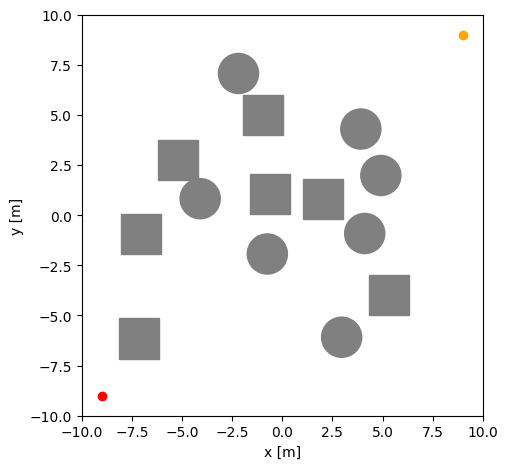

In [3]:
from envs.navigation_2d import Navigation2DEnv

env1 = Navigation2DEnv()
env1.plot()

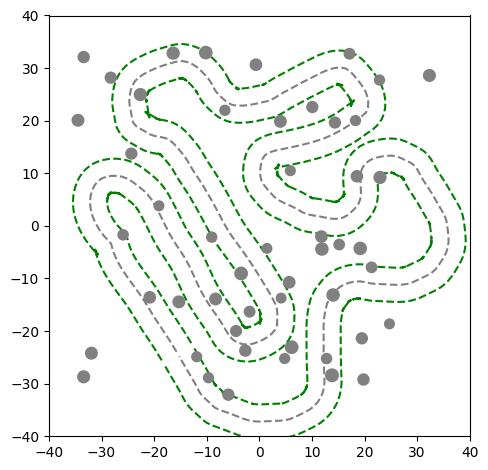

In [4]:
from envs.racing_env import RacingEnv

env2 = RacingEnv()
env2.plot()

In [5]:
import torch
import numpy as np
import time

from tqdm.notebook import tqdm

import sys
sys.path.append('/content/mppi_cem_tutorial/src')

from controller.mppi import MPPI
from controller.cem import CEM
from envs.navigation_2d import Navigation2DEnv


def main(save_mode: bool = True):
    env = Navigation2DEnv()

    # solver
    # solver = MPPI(
    #     horizon=30,
    #     num_samples=3000,
    #     dim_state=3,
    #     dim_control=2,
    #     dynamics=env.dynamics,
    #     cost_func=env.cost_function,
    #     u_min=env.u_min,
    #     u_max=env.u_max,
    #     sigmas=torch.tensor([0.5, 0.5]),
    #     lambda_=1.0,
    #     auto_lambda=False,
    # )
    solver = CEM(
        horizon=30,
        num_samples=3000,
        dim_state=3,
        dim_control=2,
        dynamics=env.dynamics,
        cost_func=env.cost_function,
        u_min=env.u_min,
        u_max=env.u_max,
        sigmas=torch.tensor([0.5, 0.5]),
        lambda_=1.0,
        auto_lambda=False,
        iters=3,
        elite_ratio=0.1,
        min_std=1e-3,
    )

    state = env.reset()
    traj.append(state[:2].cpu().numpy())

    max_steps = 500
    total_time = 0.0
    step_count = 0
    for i in range(max_steps):
        start = time.time()
        action_seq, state_seq = solver.forward(state=state)
        end = time.time()
        total_time += end - start
        step_count += 1

        state, is_goal_reached = env.step(action_seq[0, :])
        traj.append(state[:2].cpu().numpy())

        is_collisions = env.collision_check(state=state_seq)

        top_samples, top_weights = solver.get_top_samples(num_samples=300)

        if save_mode:
            env.render(
                predicted_trajectory=state_seq,
                is_collisions=is_collisions,
                top_samples=(top_samples, top_weights),
                mode="rgb_array",
            )
            # progress bar
            if i == 0:
                pbar = tqdm(total=max_steps, desc="recording video")
            pbar.update(1)

        else:
            env.render(
                predicted_trajectory=state_seq,
                is_collisions=is_collisions,
                top_samples=(top_samples, top_weights),
                mode="human",
            )
        if is_goal_reached:
            print("\nGoal Reached!")
            break

    average_time = total_time / step_count
    print("average solve time: {:.3f} ms".format(average_time * 1000))
    env.close()  # close window and save video if save_mode is True


if __name__ == "__main__":
    traj = []
    main()
    traj = np.stack(traj, axis=0)

Device: cuda


recording video:   0%|          | 0/500 [00:00<?, ?it/s]


Goal Reached!
average solve time: 121.218 ms
MoviePy - Building file video/navigation_2d_42.gif with imageio.



t:  75%|███████▌  | 110/146 [00:00<00:00, 1098.81it/s, now=None]
                                                                

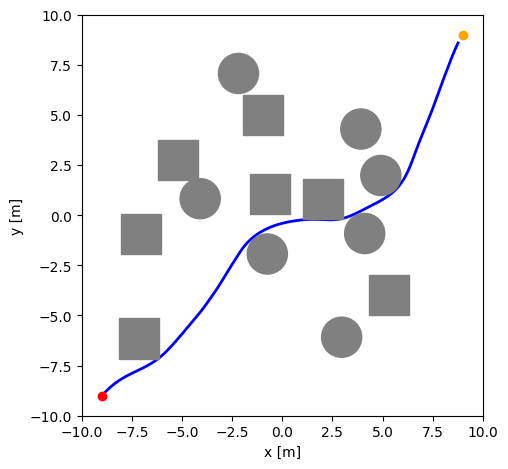

In [6]:
env1.plot()
env1._ax.plot(traj[:,0], traj[:,1], linewidth=2, color="blue")

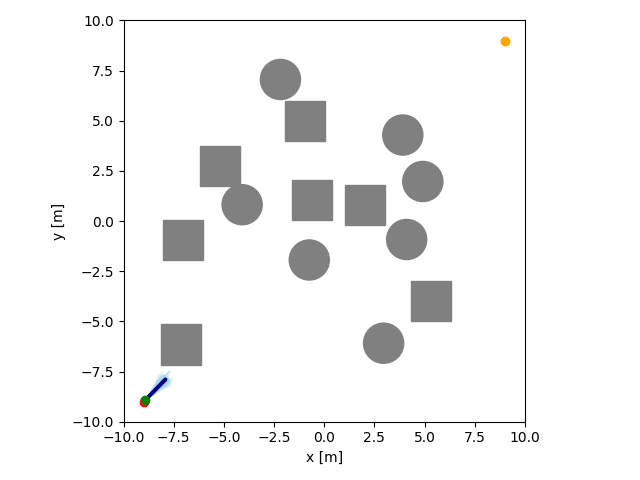

In [7]:
from IPython.display import Image

Image(filename='/content/video/navigation_2d_42.gif')

In [11]:
import torch
import numpy as np
from typing import Tuple

import time

# import gymnasium
from tqdm.notebook import tqdm

import sys
sys.path.append('/content/mppi_playground/src')

from controller.mppi import MPPI
from controller.cem import CEM
from envs.racing_env import RacingEnv
from envs.obstacle_map_2d import ObstacleMap
from envs.lane_map_2d import LaneMap

class racing_controller:
    def __init__(self, env, debug=False, device=torch.device("cuda"), dtype=torch.float32) -> None:

        self.debug = debug
        self.current_path_index = 0

        # solver
        self.solver = MPPI(
            horizon=25,
            num_samples=4000,
            dim_state=4,
            dim_control=2,
            dynamics=env.dynamics,
            cost_func=self.cost_function,
            u_min=env.u_min,
            u_max=env.u_max,
            sigmas=torch.tensor([0.5, 0.1]),
            lambda_=1.0,
            auto_lambda=False,
        )
        # self.solver = CEM(
        #     horizon=25,
        #     num_samples=4000,
        #     dim_state=4,
        #     dim_control=2,
        #     dynamics=env.dynamics,
        #     cost_func=self.cost_function,
        #     u_min=env.u_min,
        #     u_max=env.u_max,
        #     sigmas=torch.tensor([0.5, 0.1]),
        #     lambda_=1.0,
        #     auto_lambda=False,
        #     iters=3,
        #     elite_ratio=0.1,
        #     min_std=1e-3,
        # )

        # config
        self.env = env

        # cost weights
        self.Qc = 2.0  # contouring error cost
        self.Ql = 3.0  # lag error cost
        self.Qv = 2.0  # velocity cost
        self.Qo = 10000.0  # obstacle cost
        self.Qin = 0.01  # input cost
        self.Qdin = 0.5  # differential input cost

        # device and dtype
        if torch.cuda.is_available() and device == torch.device("cuda"):
            self._device = torch.device("cuda")
        else:
            self._device = torch.device("cpu")
        self._dtype = dtype

        # reference indformation (tensor)
        self.reference_path: torch.Tensor = None
        self.obstacle_map: ObstacleMap = None
        self.lane_map: LaneMap = None

    def update(self, state: torch.Tensor, racing_center_path: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Update the controller with the current state and reference path.
        Args:
            state (torch.Tensor): current state of the vehicle, shape (4,) [x, y, yaw, v]
            racing_center_path (torch.Tensor): racing center path, shape (N, 3) [x, y, yaw]
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: action sequence tensor, shape (horizon, 2) [accel, steer], state sequence tensor, shape (horizon + 1, 4) [x, y, yaw, v]
        """

        # reference
        self.reference_path, self.current_path_index = self.calc_ref_trajectory(
            state, racing_center_path, self.current_path_index, self.solver._horizon, DL=0.1, lookahead_distance=3, reference_path_interval=0.85
        )

        if self.reference_path is None and self.obstacle_map is None and self.lane_map is None:
            raise ValueError("reference path, obstacle map, and lane map must be set before calling solve method.")

        # solve
        start = time.time()
        action_seq, state_seq = self.solver.forward(state=state)
        end = time.time()
        solve_time = end - start

        if self.debug:
            print("solve time: {}".format(round(solve_time * 1000, 2)), " [ms]")

        return action_seq, state_seq

    def get_top_samples(self, num_samples = 300) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.solver.get_top_samples(num_samples=num_samples)

    def set_cost_map(self, obstacle_map: ObstacleMap, lane_map: LaneMap) -> None:
        self.obstacle_map = obstacle_map
        self.lane_map = lane_map

    def cost_function(self, state: torch.Tensor, action: torch.Tensor, info: dict) -> torch.Tensor:
        """
        Calculate cost function
        Args:
            state (torch.Tensor): state batch tensor, shape (batch_size, 4) [x, y, theta, v]
            action (torch.Tensor): control batch tensor, shape (batch_size, 2) [accel, steer]
        Returns:
            torch.Tensor: shape (batch_size,)
        """
        # info
        prev_action = info["prev_action"]
        t = info["t"] # horizon number

        # path cost
        # contouring and lag error of path
        ec = torch.sin(self.reference_path[t, 2]) * (state[:, 0] - self.reference_path[t, 0]) \
            -torch.cos(self.reference_path[t, 2]) * (state[:, 1] - self.reference_path[t, 1])
        el = -torch.cos(self.reference_path[t, 2]) * (state[:, 0] - self.reference_path[t, 0]) \
             -torch.sin(self.reference_path[t, 2]) * (state[:, 1] - self.reference_path[t, 1])

        path_cost = self.Qc * ec.pow(2) + self.Ql * el.pow(2)

        # velocity cost
        v = state[:, 3]
        v_target = self.reference_path[t, 3]
        velocity_cost = self.Qv * (v - v_target).pow(2)

        # compute obstacle cost from cost map
        pos_batch = state[:, :2].unsqueeze(1)  # (batch_size, 1, 2)
        obstacle_cost = self.obstacle_map.compute_cost(pos_batch).squeeze(1)  # (batch_size,)
        obstacle_cost += self.lane_map.compute_cost(pos_batch).squeeze(1)
        obstacle_cost = self.Qo * obstacle_cost

        # input cost
        input_cost = self.Qin * action.pow(2).sum(dim=1)
        input_cost += self.Qdin * (action - prev_action).pow(2).sum(dim=1)

        cost = path_cost + velocity_cost + obstacle_cost + input_cost

        return cost

    def calc_ref_trajectory(self, state: torch.Tensor, path: torch.Tensor,
                            cind: int, horizon: int, DL=0.1, lookahead_distance=1.0, reference_path_interval=0.5
                            ) -> Tuple[torch.Tensor, int]:
        """
        Calculate the reference trajectory for the vehicle.

        Args:
            state (torch.Tensor): current state of the vehicle, shape (4,) [x, y, yaw, v]
            path (torch.Tensor): reference path, shape (N, 3) [x, y, yaw]
            cind (int): current index of the vehicle on the path
            horizon (int): prediction horizon
            DL (float): resolution of the path
            lookahead_distance (float): distance to look ahead
            reference_path_interval (float): interval of the reference path

        Returns:
            Tuple[torch.Tensor, int]: reference trajectory tensor, shape (horizon + 1, 4) [x, y, yaw, target_v], index of the vehicle on the path
        """

        ncourse = len(path)
        xref = torch.zeros((horizon + 1, state.shape[0]), dtype=state.dtype, device=state.device)

        # Calculate the nearest index to the vehicle
        ind = min(range(len(path)), key=lambda i: np.hypot(path[i, 0].cpu().numpy() - state[0].cpu().numpy(), path[i, 1].cpu().numpy() - state[1].cpu().numpy()))
        # Ensure the index is not less than the current index
        ind = max(cind, ind)

        # Generate the rest of the reference trajectory
        travel = lookahead_distance

        for i in range(horizon + 1):
            travel += reference_path_interval
            dind = int(round(travel / DL))

            if (ind + dind) < ncourse:
                xref[i, :3] = path[ind + dind]
                xref[i, 3] = self.env.V_MAX
            else:
                xref[i, :3] = path[-1]
                # set the target velocity to zero if the vehicle reaches the end of the path
                xref[:, 3] = 0.0

        return xref, ind


def main(save_mode: bool = True):
    env = RacingEnv()

    # controller
    controller = racing_controller(env, debug=False)
    controller.set_cost_map(env._obstacle_map, env._lane_map)

    state = env.reset()
    traj.append(state[:2].cpu().numpy())
    max_steps = 500
    total_time = 0.0
    step_count = 0
    for i in range(max_steps):
        start = time.time()

        action_seq, state_seq = controller.update(state, env.racing_center_path)

        end = time.time()
        total_time += end - start
        step_count += 1

        state, is_goal_reached = env.step(action_seq[0, :])
        traj.append(state[:2].cpu().numpy())

        is_collisions = env.collision_check(state=state_seq)

        top_samples, top_weights = controller.get_top_samples(num_samples=300)

        if save_mode:
            env.render(
                action=action_seq[0, :],
                predicted_trajectory=state_seq,
                is_collisions=is_collisions,
                top_samples=(top_samples, top_weights),
                reference_trajectory=controller.reference_path,
                mode="rgb_array",
            )
            # progress bar
            if i == 0:
                pbar = tqdm(total=max_steps, desc="recording video")
            pbar.update(1)

        else:
            env.render(
                action=action_seq[0, :],
                predicted_trajectory=state_seq,
                is_collisions=is_collisions,
                top_samples=(top_samples, top_weights),
                reference_trajectory=controller.reference_path,
                mode="human",
            )
        if is_goal_reached:
            print("\nGoal Reached!")
            break

    average_time = total_time / step_count
    print("average solve time: {}".format(average_time * 1000), " [ms]")
    env.close()  # close window and save video if save_mode is True


if __name__ == "__main__":
    traj = []
    main()
    traj = np.stack(traj, axis=0)

Device: cuda


recording video:   0%|          | 0/500 [00:00<?, ?it/s]


Goal Reached!
average solve time: 444.38651701983287  [ms]
MoviePy - Building file video/racing_42.gif with imageio.


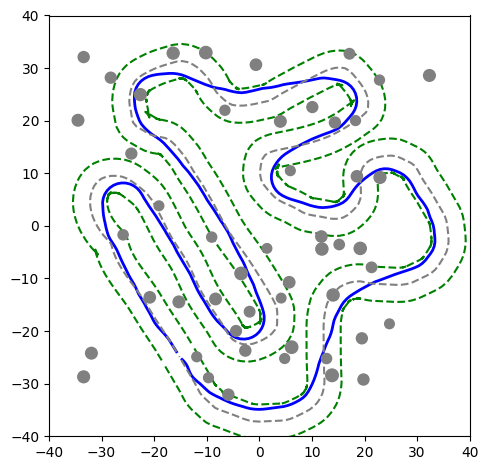

In [12]:
env2.plot()
env2._ax.plot(traj[:,0], traj[:,1], linewidth=2, color="blue")

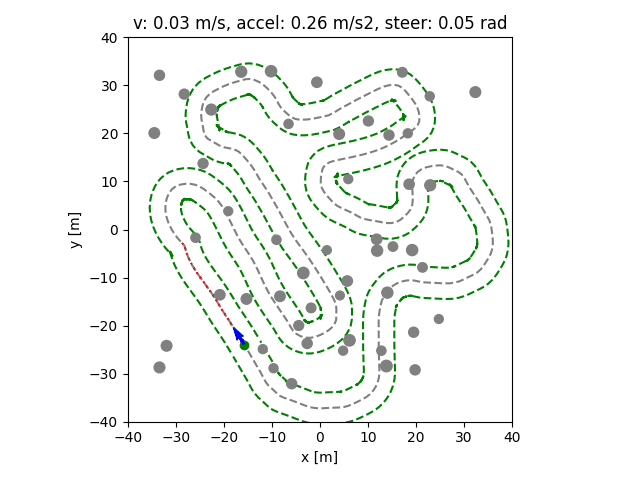

In [13]:
from IPython.display import Image

Image(filename='/content/video/racing_42.gif')